# Richter's predicter entry
Below is the basis for my entry to the Richters predicter open competition hosted by Drivendatausing Catboost.

https://www.drivendata.org/competitions/57/nepal-earthquake/    

"""   
Based on aspects of building location and construction, your goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.

This is an intermediate-level practice competition.

The data was collected through surveys by Kathmandu Living Labs and the Central Bureau of Statistics, which works under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.   

"""

### Patrickwalsh1995@gmail.com
### https://github.com/pat42w/
### https://www.drivendata.org/users/PatW42/

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import cufflinks as cf
import plotly.offline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
pd.set_option('display.max_columns', 38)

### Update this 
DATA_DIR = "C:/Users/YOUR_NAME/Desktop/Richter's Predictor"


## Data import

In [2]:
#Data downloaded from https://www.drivendata.org/competitions/57/nepal-earthquake/data/
train_values = pd.read_csv(DATA_DIR +'/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR +'/train_labels.csv', index_col='building_id')

test_values = pd.read_csv(DATA_DIR+'/test_values.csv', index_col='building_id')

## Preview the data

In [3]:
train_values.head(5)

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8                  9   

            land_surface_condition foundation_type roof_type  \
building_id                                                    
802906                           t               r         n   
28830                            o               r         n   
94947                            t               r         n   
590882                           t               r         n   
201944                           t               r         n   

            ground_floor_type other_floor_type position plan_configuration  \
building_id                                                                  
802906                      f                q        t                  d   
28830                       x                q        s                  d   
94947                       f                x        t                  d   
590882                      f                x        s                  d   
201944                      f                x        s                  d   

             has_superstructure_adobe_mud  \
building_id                                 
802906                                  1   
28830                                   0   
94947                                   0   
590882                                  0   
201944                                  1   

             has_superstructure_mud_mortar_stone  \
building_id                                        
802906                                         1   
28830                                          1   
94947                                          1   
590882                                         1   
201944                                         0   

             has_superstructure_stone_flag  \
building_id                                  
802906                                   0   
28830                                    0   
94947                                    0   
590882                                   0   
201944                                   0   

             has_superstructure_cement_mortar_stone  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                             0   
590882                                            0   
201944                                            0   

             has_superstructure_mud_mortar_brick  \
building_id                                        
802906                                         0   
28830                                          0   
94947                                          0   
590882                                         0   
201944                                         0   

             has_superstructure_cement_mortar_brick  \
building_id                                           
802906                                            0   
28830                                             0   
94947                                             0   
59088

## Train Dataset Profile
I have found using this very useful to get to grips with new data

In [4]:
df_profile=train_values.join(train_labels)
train_profile=df_profile.profile_report(title="Richter's Train Dataset Pandas profile")

#This is a html file and can be saved and opeded in another tab
#train_profile.to_file(output_file=DATA_DIR+"/Richter's Train Dataset Pandas profile.html") 

train_profile

## Test Dataset Profile

In [5]:
test_profile=test_values.profile_report(title="Richter's Test Dataset Pandas profile")
#This is a html file and can be saved and opeded in another tab
#test_profile.to_file(output_file=DATA_DIR+"/Richter's Test Dataset Pandas profile.html")
test_profile

## Further explore the data & show any corrolations

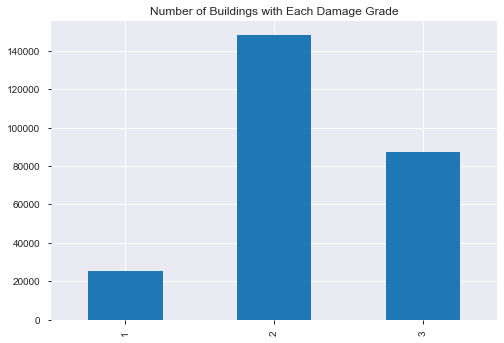

In [6]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

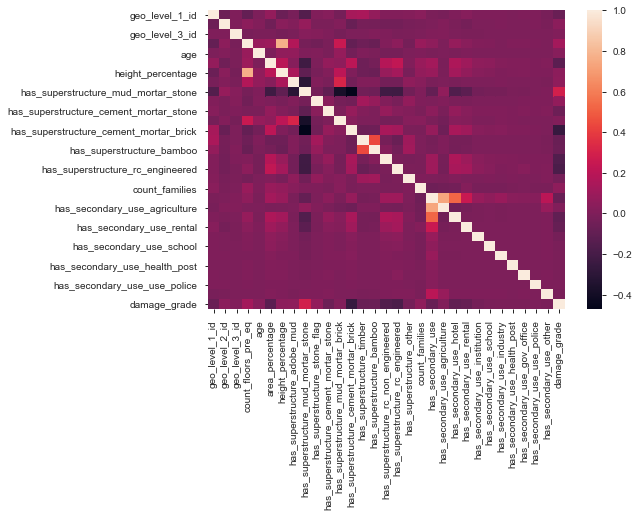

In [7]:
#correlation heat map
sns.heatmap(train_values.join(train_labels).corr(), annot=False, fmt=".2f")
plt.show()

## Preprocessing   
I dont do any preprocessing on this data set as we have no missing data, and I could see no other  advantageous preproccesing to do.   
I do pull out the categorica features as CatboostClassifer requires this input.

If you find some please let me know :)

In [10]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [11]:
cat_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status','count_floors_pre_eq', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

## Creating & optomising the Model

In [ ]:

print(format('How to find optimal parameters for CatBoost using GridSearchCV for Classification','*^82'))   
# Split the training data set
X = train_values; y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('Data loaded')

#Initialise the catboost classifier, if you have no GPU on your machine you can remove task_type="GPU" 
model = CatBoostClassifier(eval_metric='TotalF1', task_type="GPU",cat_features=cat_cols)

#Choose parameters to test here
parameters = {'depth':[2,4,6,8,10,12],
            'iterations':[10,100,500,1000,5000],
            'learning_rate':[0.02,0.05,0.06,0.07], 
            'l2_leaf_reg':[3,5,7,9],
            'border_count':[11,13,15,17]}
print('Paramaters defined')

#Initialise the Gridsearch, cv is set to 2 for speed.
randm = GridSearchCV(estimator=model, param_grid = parameters,cv = 2)
randm.fit(X_train, y_train)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")


## Use optomised Hyperparameters
I havn't updated these below they are just the default, update with the output from above after you test your hyperparameters

In [16]:
from sklearn.metrics import f1_score

print("Resample the train test split & try these parameters set")
X = train_values; y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#input best params here from randm.best_params_
model = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, task_type="GPU",cat_features=cat_cols)
model.fit(X_train, y_train)
preds=model.predict(X_test)

#f1 score is the metric used in the competition
accuracy=f1_score(y_test,preds,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy)
print('\n Benchmark model was: 0.5815')

#Using Just the default hyperparameters we see a 0.73 score on our training data a considerable uplift on the benchmark model used on the initial leaderboard

Resample the train test split & try these parameters set
Score on test set

0.736171600698375

 Benchmark model was: 0.5815


### Prep the test set & get predictions

In [23]:
test_values = pd.read_csv(DATA_DIR+'/test_values.csv', index_col='building_id')                        

predictions = model.predict(test_values)

In [24]:
# Ensure the predictions are in teh correct submission format
submission_format = pd.read_csv(DATA_DIR+'/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission['damage_grade'] =my_submission['damage_grade'].astype(int)
my_submission.head()

damage_grade
building_id              
300051                  3
99355                   2
890251                  2
745817                  1
421793                  3

In [26]:
my_submission.to_csv(DATA_DIR +'/git_submission.csv')


## Review Best features

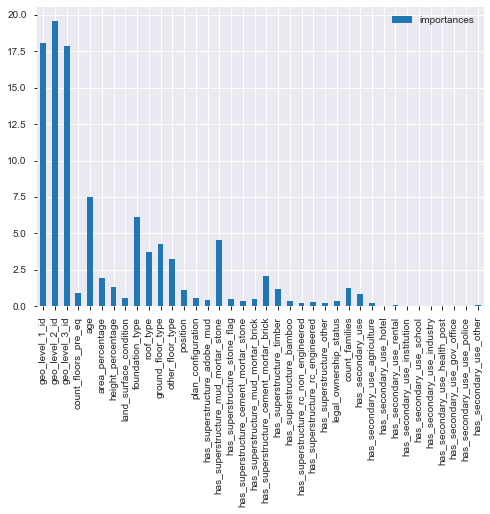

In [22]:
#get feature importances and graph, could look further into thesee to improve the model further
df_importances=pd.DataFrame(model.feature_importances_)
df_importances.index=train_values.columns
df_importances.columns=['importances']
df_importances.plot.bar()